<a href="https://colab.research.google.com/github/simon108018/Machine-Learning/blob/master/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, initializers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import tensorflow_datasets as tfds
#tfds.list_builders()

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/cifar10/models'
model = tf.keras.models.load_model(model_dir + "/Best-model-VGG16.h5")

In [ ]:
train_data, info = tfds.load("cifar10", split="train[10%:]", with_info = True)
#print(info)
valid_data = tfds.load("cifar10", split="train[:10%]")
test_data = tfds.load("cifar10", split="test")

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteR3Q3L8/cifar10-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.0.incompleteR3Q3L8/cifar10-test.tfrecord


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.0. Subsequent calls will reuse this data.


In [ ]:
def parse_aug_fn(dataset):
    def zoom(x, sh = 299, sw = 299):
        x = tf.image.resize(x, (sh, sw))
        return x
    
    # 影像標準化
    x = tf.cast(dataset['image'], tf.float32) / 255.
    # 影像放大到224*224
    x = zoom(x)
    y = tf.one_hot(dataset['label'], 10)
    y = y
    
    return x, y

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
train_num = int(info.splits["train"].num_examples/10)*9
train_data = train_data.shuffle(train_num)
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_data = valid_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_data = test_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)


In [ ]:
#模型儲存目錄
model_dir = 'cifar10/models'
if os.path.isdir(model_dir):
    print("已存在路徑「{}」".format(model_dir))
else:
    print("已建立路徑「{}」".format(model_dir))
    os.makedirs(model_dir)

已建立路徑「cifar10/models」


In [ ]:
#回調函數
log_dir = os.path.join('cifar10','VGG16')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-VGG16.h5', 
                                             monitor='val_categorical_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
# 設定停止訓練的條件(當Accuracy超過30迭代沒有上升的話訓練會終止)
model_esp = keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=30)

In [ ]:
input_shape = (299, 299)
base_model = tf.keras.applications.VGG16(include_top = False,
                                              weights="imagenet",
                                              pooling='avg',
                                              input_shape=input_shape+(3,)
                                              )
model=tf.keras.Sequential([
    base_model,
    layers.Dense(128,activation='relu', kernel_initializer = initializers.he_normal()),
    layers.Dense(128,activation='relu', kernel_initializer = initializers.he_normal()),
    layers.Dense(10,activation='softmax', kernel_initializer = initializers.he_normal())
])

In [ ]:
for layer in model.layers:
    layer.trainable = False
# 或者使用如下方法冻结所有层
# model.trainable = False 
model.layers[-1].trainable = True
model.layers[-2].trainable = True
model.layers[-3].trainable = True

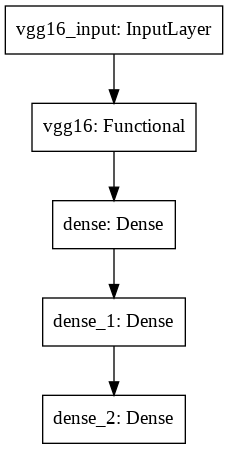

In [ ]:
plot_model(model)

In [ ]:
for x in model.trainable_weights:
    print(x.name)

dense/kernel:0
dense/bias:0
dense_1/kernel:0
dense_1/bias:0
dense_2/kernel:0
dense_2/bias:0


In [ ]:
#優化器、損失函數，指標函數
model.compile(keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 14,798,154
Trainable params: 83,466
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
history = model.fit(train_data,
                   epochs=200,
                   validation_data = valid_data,
                   callbacks=[model_cbk, model_mckp, model_esp])

Epoch 1/200
1407/1407 [==============================] - 702s 499ms/step - loss: 1.6933 - categorical_accuracy: 0.3797 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00
Epoch 2/200
1407/1407 [==============================] - 708s 503ms/step - loss: 1.4141 - categorical_accuracy: 0.4891 - val_loss: 1.3362 - val_categorical_accuracy: 0.5266
Epoch 3/200
1407/1407 [==============================] - 703s 500ms/step - loss: 1.3209 - categorical_accuracy: 0.5274 - val_loss: 1.3307 - val_categorical_accuracy: 0.5042
Epoch 4/200
1407/1407 [==============================] - 686s 488ms/step - loss: 1.2683 - categorical_accuracy: 0.5489 - val_loss: 1.2791 - val_categorical_accuracy: 0.5504
Epoch 5/200
1407/1407 [==============================] - 710s 504ms/step - loss: 1.2279 - categorical_accuracy: 0.5623 - val_loss: 1.2190 - val_categorical_accuracy: 0.5766
Epoch 6/200
1407/1407 [==============================] - 806s 573ms/step - loss: 1.1953 - categorical_accuracy: 0.5724 - val_lo

1407/1407 [==============================] - 687s 488ms/step - loss: 0.7804 - categorical_accuracy: 0.7221 - val_loss: 1.0359 - val_categorical_accuracy: 0.6510
Epoch 96/200
1407/1407 [==============================] - 689s 490ms/step - loss: 0.7820 - categorical_accuracy: 0.7237 - val_loss: 1.0002 - val_categorical_accuracy: 0.6690
Epoch 97/200
1407/1407 [==============================] - 727s 517ms/step - loss: 0.7694 - categorical_accuracy: 0.7245 - val_loss: 1.0219 - val_categorical_accuracy: 0.6612
Epoch 98/200
1407/1407 [==============================] - 716s 509ms/step - loss: 0.7774 - categorical_accuracy: 0.7248 - val_loss: 1.0225 - val_categorical_accuracy: 0.6590
Epoch 99/200
1407/1407 [==============================] - 694s 493ms/step - loss: 0.7737 - categorical_accuracy: 0.7244 - val_loss: 0.9723 - val_categorical_accuracy: 0.6738
Epoch 100/200
1407/1407 [==============================] - 691s 491ms/step - loss: 0.7695 - categorical_accuracy: 0.7263 - val_loss: 1.0281 - v

In [ ]:
model.evaluate(train_data)

1407/1407 [==============================] - 614s 436ms/step - loss: 0.7264 - categorical_accuracy: 0.7442


[0.7263973355293274, 0.7441555261611938]

In [ ]:
model.evaluate(test_data)

313/313 [==============================] - 139s 445ms/step - loss: 0.9825 - categorical_accuracy: 0.6666


[0.9824972748756409, 0.6665999889373779]